In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split # for splitting the training data

from sklearn.tree import DecisionTreeRegressor as DTR # different regression model

# for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
Kfold_validation = KFold(10) # use k=10 for cross validation

# Calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load and validate the training and testing data

In [2]:
# Load the preprocessed training data
train_processed = pd.read_csv('train_processed.csv')
print("Training data shape:", train_processed.shape)
print("Columns:", train_processed.columns.tolist())

# Separate features (X) and target (y)
y_train = train_processed['Price']
X_train = train_processed.drop(columns=['Price'])


print(f"\nFeatures shape: {X_train.shape}")
print(f"Target shape: {y_train.shape}")
print(f"\nTarget statistics:")
print(f"Mean price: {y_train.mean():.2f}")
print(f"Min price: {y_train.min():.2f}")
print(f"Max price: {y_train.max():.2f}")

# Split data into training and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)
print(f"Training set: {X_train_split.shape}")
print(f"Validation set: {X_val.shape}")

Training data shape: (4336, 21)
Columns: ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'No. of Doors', 'Price', 'Age', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Fuel_Type_CNG', 'Fuel_Type_LPG', 'Transmission_Manual', 'Transmission_Automatic', 'Owner_Type_First', 'Owner_Type_Second', 'Owner_Type_Third', 'Owner_Type_Fourth & Above', 'Colour_Others', 'Colour_Black/Silver', 'Colour_White']

Features shape: (4336, 20)
Target shape: (4336,)

Target statistics:
Mean price: 9.65
Min price: 0.44
Max price: 160.00
Training set: (3468, 20)
Validation set: (868, 20)


In [3]:
# Train a Decision Tree Regressor model
print("Training Decision Tree model...")
dt_model = DTR(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)

dt_model.fit(X_train_split, y_train_split)

# Make predictions
y_pred_train_dt = dt_model.predict(X_train_split)
y_pred_val_dt = dt_model.predict(X_val)

# Calculate MAPE
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Evaluate the model
print("\n=== Decision Tree Model Performance ===")
print(f"\nTraining MAPE: {calculate_mape(y_train_split, y_pred_train_dt):.2f}%")
print(f"Validation MAPE: {calculate_mape(y_val, y_pred_val_dt):.2f}%")

# perform cross validation to evaluate the testing error
dt_model_cross_validation_result = cross_val_score(dt_model,X_train,y_train,cv = Kfold_validation)

print("\n=== Cross validation result ===")
print(dt_model_cross_validation_result)
print("\n=== Cross validation mean score ===")
print(np.mean(dt_model_cross_validation_result))

Training Decision Tree model...

=== Decision Tree Model Performance ===

Training MAPE: 19.90%
Validation MAPE: 21.22%

=== Cross validation result ===
[0.82714785 0.7490727  0.79332155 0.85441509 0.82241399 0.88753688
 0.82001541 0.84698573 0.86794056 0.74969493]

=== Cross validation mean score ===
0.8218544674742476


In [4]:
# Load test_processed.csv and predict the price
test_processed = pd.read_csv('test_processed.csv')
print("Test data shape:", test_processed.shape)
print("Test data columns:", test_processed.columns.tolist())

# Save ID column if it exists
X_test = test_processed.drop(columns=['ID'])

print(f"\nTest features shape: {X_test.shape}")
print(f"Training features shape: {X_train.shape}")

# Verify columns match between train and test
print(f"\nColumns match: {list(X_train.columns) == list(X_test.columns)}")

Test data shape: (1491, 21)
Test data columns: ['ID', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'No. of Doors', 'Age', 'Fuel_Type_Diesel', 'Fuel_Type_Petrol', 'Fuel_Type_CNG', 'Fuel_Type_LPG', 'Transmission_Manual', 'Transmission_Automatic', 'Owner_Type_First', 'Owner_Type_Second', 'Owner_Type_Third', 'Owner_Type_Fourth & Above', 'Colour_Others', 'Colour_Black/Silver', 'Colour_White']

Test features shape: (1491, 20)
Training features shape: (4336, 20)

Columns match: True


In [5]:
# Make predictions using Decision Tree model
y_pred_dt = dt_model.predict(X_test)

print("=== Decision Tree Predictions ===")
print(f"Predicted prices - Min: {y_pred_dt.min():.2f}, Max: {y_pred_dt.max():.2f}, Mean: {y_pred_dt.mean():.2f}")

# Save ID and predicted Price to CSV file
submission_dt = pd.DataFrame({
    'ID': test_processed['ID'],
    'Price': y_pred_dt
})

submission_dt.to_csv('submission_decision_tree.csv', index=False)
print("\nDecision Tree submission saved as 'submission_decision_tree.csv'")

=== Decision Tree Predictions ===
Predicted prices - Min: 0.83, Max: 70.36, Mean: 9.59

Decision Tree submission saved as 'submission_decision_tree.csv'



=== Top 15 Most Important Features (XGBoost) ===
               feature  importance
                 Power    0.712724
                   Age    0.173329
                Engine    0.040294
     Kilometers_Driven    0.022069
                 Seats    0.019558
               Mileage    0.019445
          Colour_White    0.004866
Transmission_Automatic    0.003913
   Transmission_Manual    0.003028
      Owner_Type_First    0.000436
      Fuel_Type_Petrol    0.000209
     Owner_Type_Second    0.000107
         Colour_Others    0.000024
         Fuel_Type_CNG    0.000000
          No. of Doors    0.000000


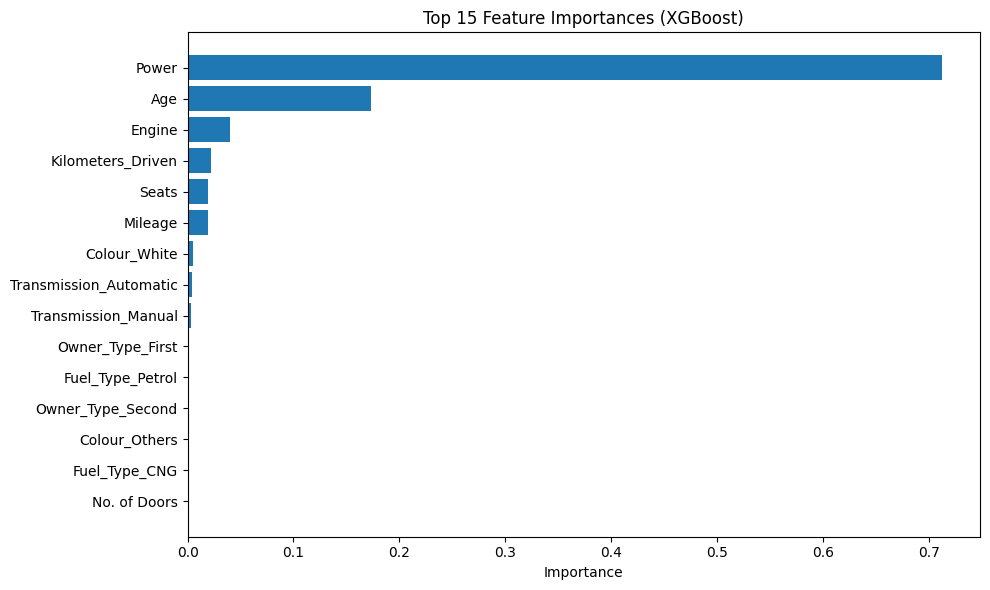

In [6]:
# Feature importance from XGBoost
import matplotlib.pyplot as plt

feature_importance_xgb = pd.DataFrame({
    'feature': X_train.columns,
    'importance': dt_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== Top 15 Most Important Features (XGBoost) ===")
print(feature_importance_xgb.head(15).to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_xgb.head(15)['feature'], feature_importance_xgb.head(15)['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()